In [1]:
import torch
from torch.nn import Sequential, Linear, ReLU, Softmax
import numpy as np
import json
import socket
from time import time
import os
os.system("pip install matplotlib")
import matplotlib.pyplot as plt

In [2]:
steps_per_rollout = []
reward_per_rollout = []

In [3]:
"""
Simple Neural Net
Initially, input is features, output is action
"""
FEATURE_NUM = 14
ACTION_NUM = 10



class SimpleNet:
    def __init__(self):                 
        hidden_size = 64

        self.device = torch.device("cuda")

        self.neural_net = Sequential(
            # feature size by hidden size
            Linear(FEATURE_NUM, hidden_size),
            ReLU(),
            Linear(hidden_size, hidden_size),
            ReLU(),
            # hidden size by action size
            Linear(hidden_size, ACTION_NUM),
            Softmax(dim=-1)
        ).to(self.device)
        self.optimizer = torch.optim.Adam(self.neural_net.parameters(), lr=8e-3)
        self.gamma = 0.97
        self.num_backward = 0
        self.total_steps = 0

        self.ep_count = 0
        self.ep_steps = 0
        self.plt_x = []
        self.plt_y = []

        # If weights already exist, load them
        if os.path.exists("pretrained_weights.pt"):
            print("Loading pretrained weights")
            self.neural_net.load_state_dict(torch.load("pretrained_weights.pt", map_location="cuda:0"))

        self.reset()

    def reset(self):
        self.ep_count += 1
        self.plt_x = np.append(self.plt_x, self.ep_count)
        self.plt_y = np.append(self.plt_y, self.ep_steps)

        self.ep_feats = []
        self.ep_rewards = []
        self.ep_actions = []
        self.ep_steps = 0

    def forward(self, input_feats):
        # Take as input a featurized state, output action probs
        probs = self.neural_net(input_feats.to(self.device))
        # Randomly select action according to probs
        return probs
    
    def get_action(self, input_feats):
        self.total_steps += 1
        self.ep_steps += 1
        probs = self.forward(input_feats)
        action = np.random.choice(probs.shape[0], p=probs.cpu().detach().numpy())
        # action = int(np.argmax(probs.cpu().detach().numpy())) # Deterministic
        self.ep_feats.append(input_feats)
        self.ep_actions.append(action)
        return action

    def backward(self):
        # Ignore if websocket returned for no reason
        self.num_backward += 1
        log_probs = []
        
        # Get log probs for features
        for feats in self.ep_feats[1:]:
            log_probs.append(torch.log(self.forward(feats)))

        # convert log probs and actions to tensors
        log_probs = torch.stack(log_probs).to(self.device)
        actions = torch.IntTensor(self.ep_actions).to(self.device)

        # Compute discounted returns
        disc_rets = torch.zeros(actions.shape[0])
        for i in range(1, len(self.ep_rewards)):
            disc_rets[i-1] = self.discounted_return(self.ep_rewards[i:])
        disc_rets = disc_rets.to(self.device)

        # Compute loss
        # Page 328: http://www.incompleteideas.net/book/RLbook2020.pdf
        sel_log_probs = disc_rets * log_probs[np.arange(len(self.ep_actions)), self.ep_actions]
        loss = -sel_log_probs.mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Save rollout stats for plotting
        steps_per_rollout.append(len(self.ep_feats))

        self.reset()

        # Every 10 backward passes, save the model
        if self.num_backward % 5 == 0:
            print(f"Saving model. Num total steps={self.total_steps}. Num backward passes={self.num_backward}")
            start = time()
            torch.save(self.neural_net.state_dict(), "pretrained_weights.pt")
        return 0

    def discounted_return(self, rewards):
        return np.dot(self.gamma ** np.arange(len(rewards)), rewards)

In [4]:
# Handle json

def convert_to_feats(response_dict):
    """Takes a response dictionary and returns tensor of features"""
    return torch.Tensor(
        (
            response_dict['feat1'],
            response_dict['feat2'],
            response_dict['feat3'],
            response_dict['feat4'],
            response_dict['feat5'],
            response_dict['feat6'],
            response_dict['feat7'],
            response_dict['feat8'],
            response_dict['feat9'],
            response_dict['feat10'],
            response_dict['feat11'],
            response_dict['feat12'],
            response_dict['feat13'],
            response_dict['feat14'],
        )
    )

def handle_response(response, net: SimpleNet):
    """Take as input a websocket response from C#, return serialized data to send back"""
    # Initialize response
    instruction = ''
    action = 0
    if response is None:
        print("Response none")
        return {}
    response_dict = json.loads(response)

    # Store the reward for the previous action. 
    # Don't worry about the first one in the array, it will be ignored
    net.ep_rewards.append(response_dict['reward'])

    # Handle forward pass
    if response_dict['instruction'] == 'forward':
        features = convert_to_feats(response_dict)
        action = net.get_action(features)
        instruction = 'step'
    elif response_dict['instruction'] == 'update_weights':
        instruction = 'reset'
        last_feats = convert_to_feats(response_dict)
        net.ep_feats.append(last_feats)
        start = time()
        net.backward()
        print(f"Took {time() - start:.4f} seconds to compute backward pass")
        

    json_return_dict = {
        'instruction': instruction,
        'action': action,
    }
    
    return json_return_dict

{'instruction': 'init', 'action': 0}
{'instruction': 'step', 'action': 6}
{'instruction': 'step', 'action': 0}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 7}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 2}
{'instruction': 'step', 'action': 2}
{'instruction': 'step', 'action': 6}
{'instruction': 'step', 'action': 7}
{'instruction': 'step', 'action': 1}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 0}
{'instruction': 'step', 'action': 7}
{'instruction': 'step', 'action': 3}
{'instruction': 'step', 'action': 7}
{'instruction': 'step', 'action': 1}
{'instruction': 'step', 'action': 6}
{'instruction': 'step', 'action': 6}
{'instruction': 'step', 'action': 2}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 7}
{'instruction': 'step', 'action': 6}
{'instruction': 'step', 'action': 3}
{

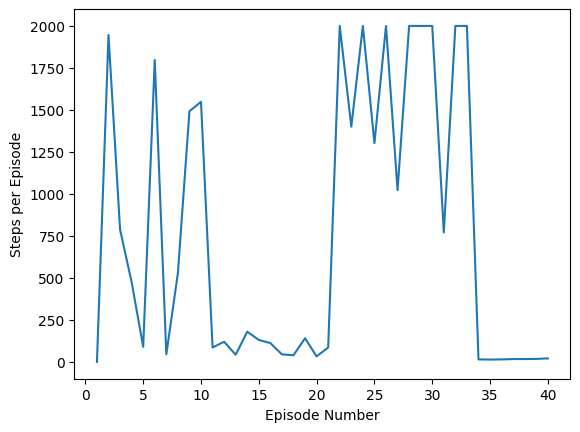

{'instruction': 'reset', 'action': 0}


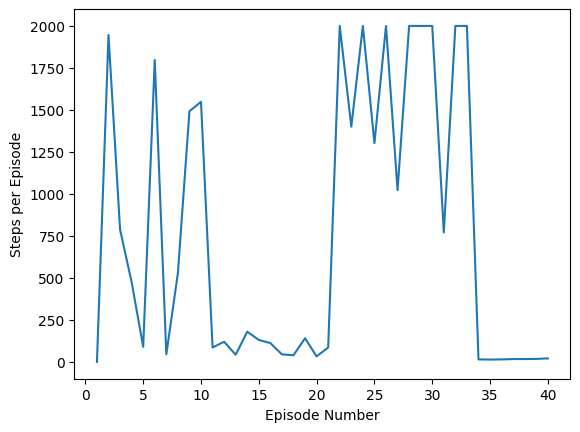

{'instruction': 'step', 'action': 9}


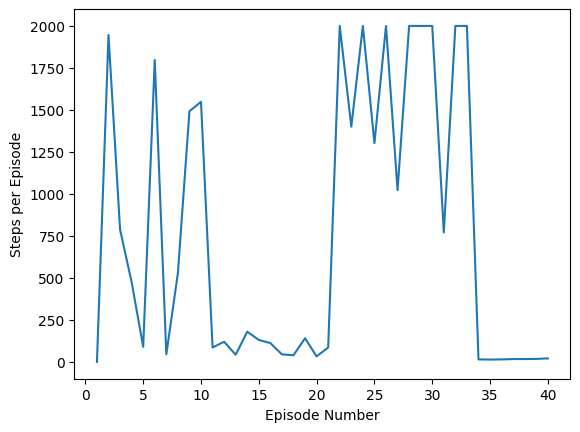

{'instruction': 'step', 'action': 8}


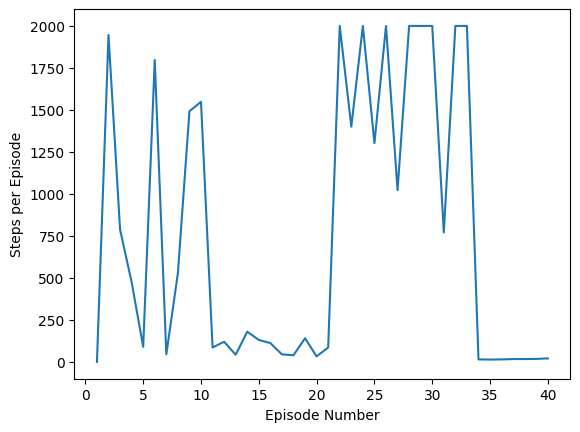

{'instruction': 'step', 'action': 4}


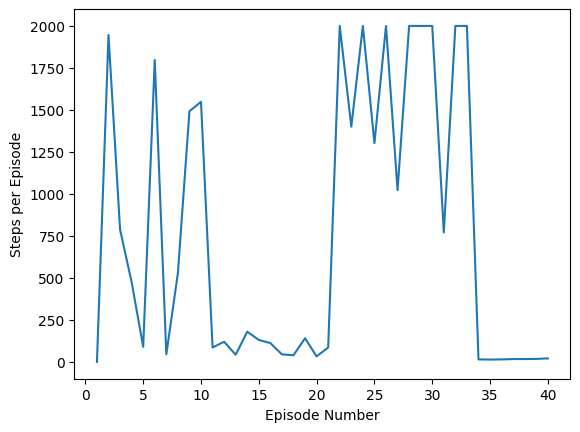

{'instruction': 'step', 'action': 2}


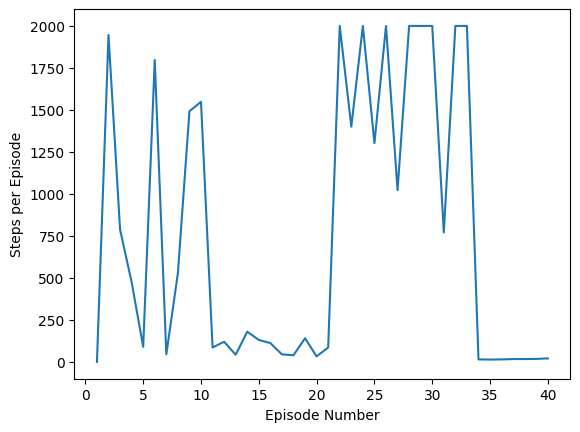

{'instruction': 'step', 'action': 4}


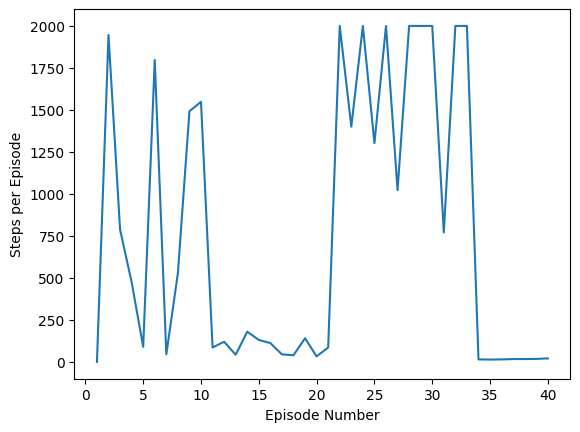

{'instruction': 'step', 'action': 8}


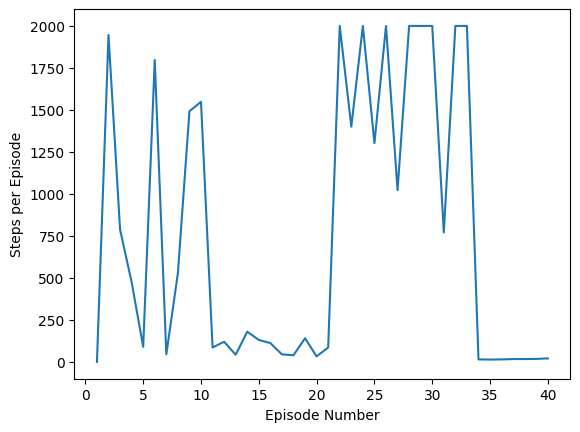

{'instruction': 'step', 'action': 2}


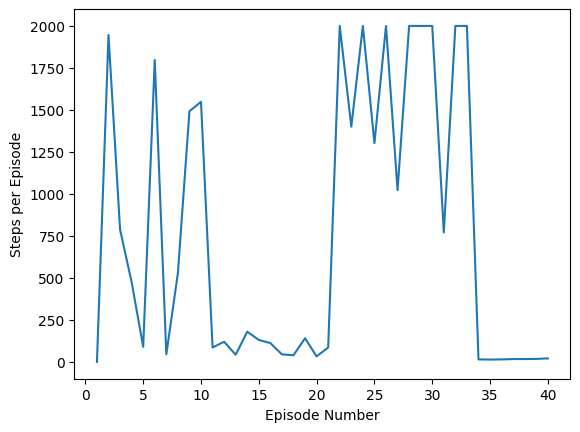

{'instruction': 'step', 'action': 4}


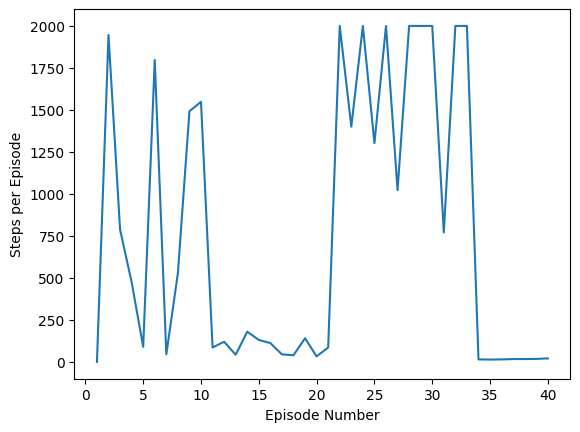

{'instruction': 'step', 'action': 1}


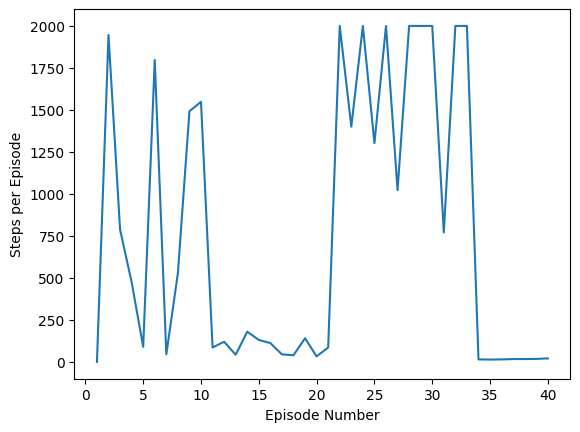

{'instruction': 'step', 'action': 8}


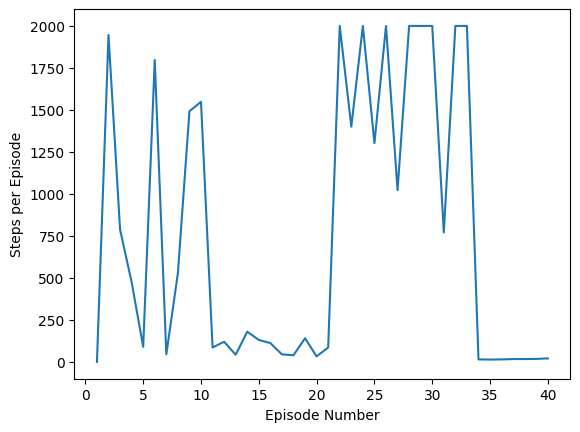

{'instruction': 'step', 'action': 2}


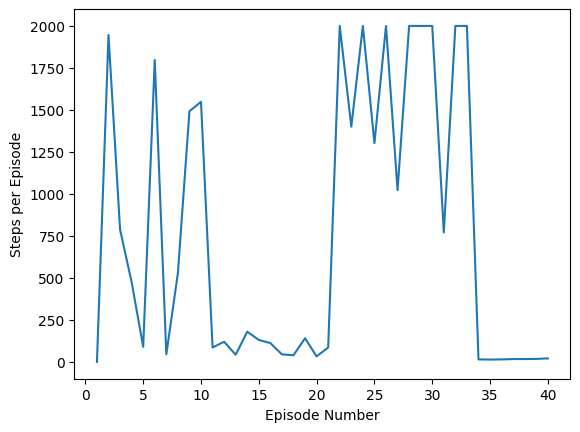

{'instruction': 'step', 'action': 4}


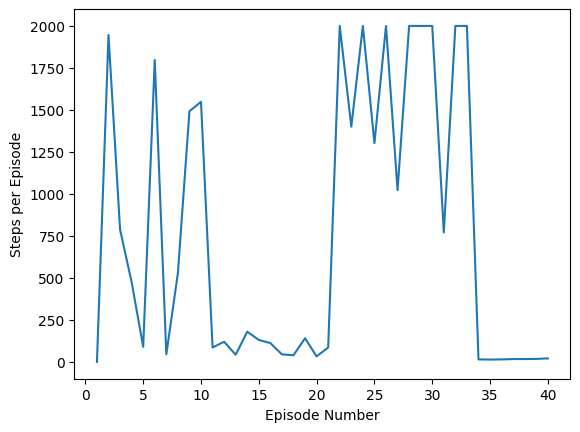

{'instruction': 'step', 'action': 4}


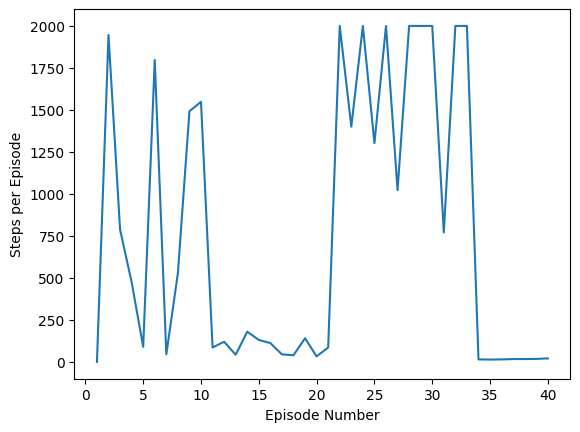

{'instruction': 'step', 'action': 5}


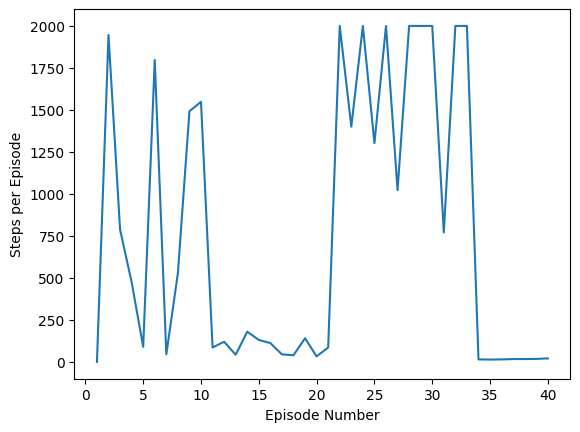

{'instruction': 'step', 'action': 1}


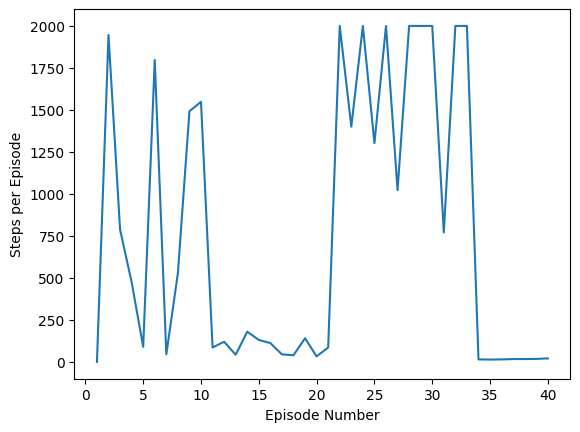

{'instruction': 'step', 'action': 9}


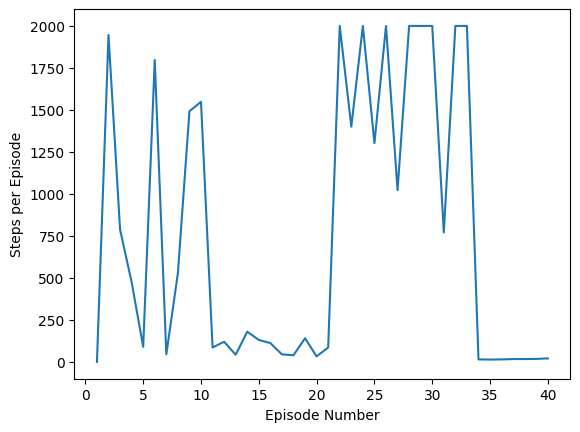

{'instruction': 'step', 'action': 9}


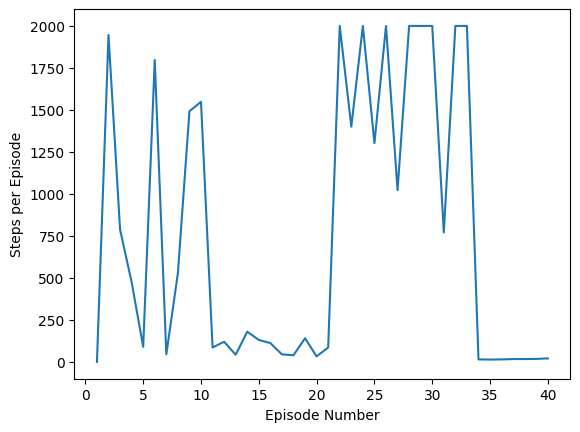

{'instruction': 'step', 'action': 8}


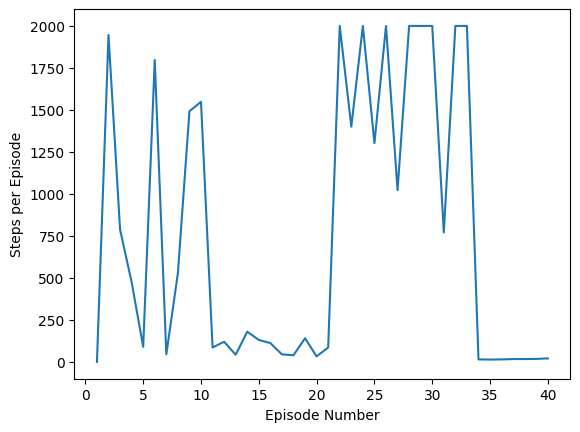

{'instruction': 'step', 'action': 1}


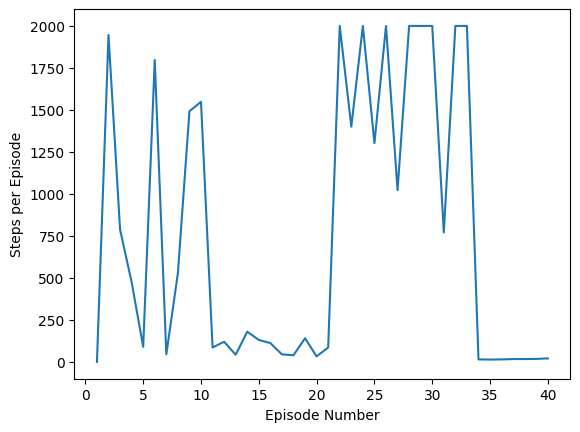

{'instruction': 'step', 'action': 4}


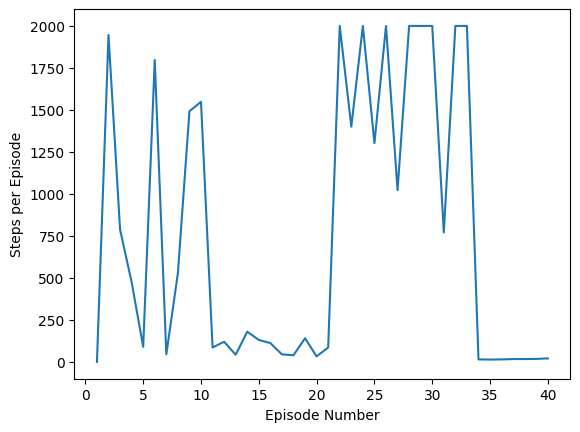

{'instruction': 'step', 'action': 4}


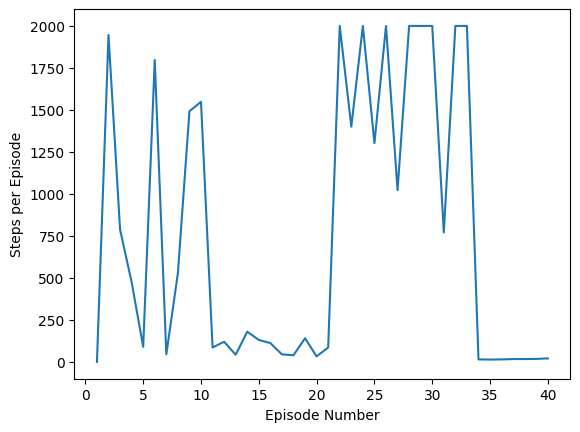

{'instruction': 'step', 'action': 4}


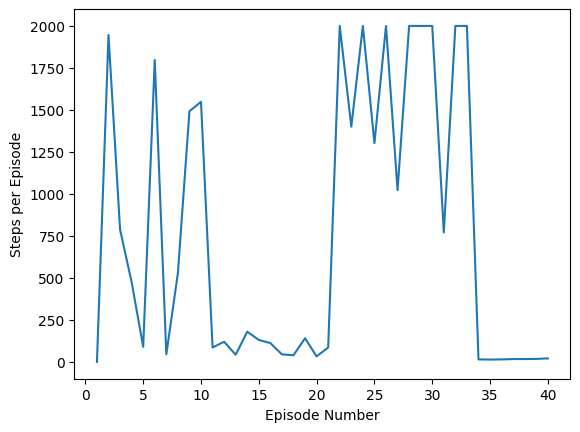

{'instruction': 'step', 'action': 4}
Saving model. Num total steps=30376. Num backward passes=40
Took 0.0563 seconds to compute backward pass
{'instruction': 'reset', 'action': 0}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 1}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 1}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 5}
{'instruction': 'step', 'action': 8}
{'instruction': 'step', 'action': 3}
{'instruction': 'step', 'action': 8}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 2}
{'instruction': 'step', 'action': 8}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 4}
{'instruction': 'step', 'action': 9}
{'instruction': 'step', 'action': 4}
{'inst

KeyboardInterrupt: 

In [5]:
host, port = "127.0.0.1", 25001

# SOCK_STREAM means TCP socket
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

neural_net = SimpleNet()
request = {
    'instruction': 'init',
    'action': 0,
}

def on_receive(message):
    print(message)

try:
    # Connect to the server and send the data
    sock.connect((host, port))

    start = 0

    while(True):
        print(request)
        request = json.dumps(request)
        sock.sendall(request.encode("utf-8"))
        response = sock.recv(1024).decode("utf-8")
        #print(f"Took {time() - start:.4f} between, that's {1/(time() - start):.2f} Hz")
        start = time()
        request = handle_response(response, neural_net)

        if neural_net.ep_count == 40:
            plt.plot(neural_net.plt_x, neural_net.plt_y)
            plt.xlabel("Episode Number")
            plt.ylabel("Steps per Episode")
            
            plt.savefig("policy_gradient_plot.png")
            plt.show()
finally:
    sock.close()

In [ ]:
for rollout in steps_per_rollout:
    print(rollout)